Getting a feeling for how extreme the distribution of l2 bitsize should be theoretically.

expected: 3535.533905932738


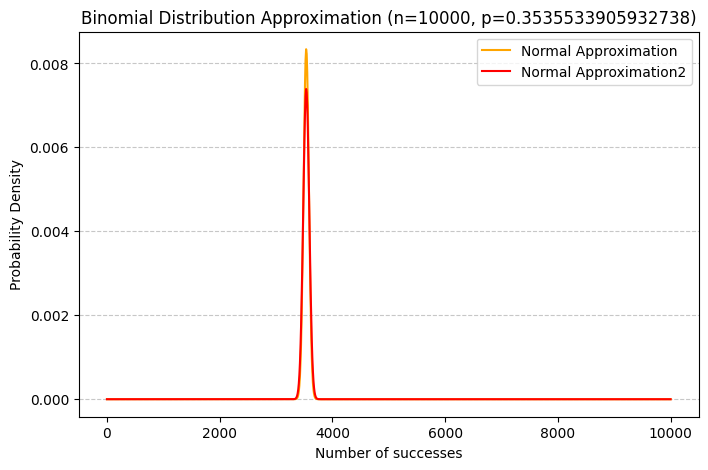

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

# Parameters for the binomial distribution
n = 10000  # Number of trials
p = 5000 / n * np.sqrt(0.5)  # Probability of success on each trial
print(f'expected: {n * p}')

# Check if normal approximation is appropriate
if n * p * (1 - p) > 10:
    # Normal approximation
    mu = n * p
    sigma = np.sqrt(n * p * (1 - p))
    x = np.linspace(0, n, 1000)  # Sample 1000 points
    pdf = norm.pdf(x, mu, sigma)  # Normal PDF approximation
    palt = 5000 / 20000 * np.sqrt(0.5)
    pdf2 = norm.pdf(x, 20000*palt,np.sqrt(20000 * palt * (1 - palt)))

    plt.figure(figsize=(8, 5))
    plt.plot(x, pdf, label='Normal Approximation', color='orange')
    plt.plot(x, pdf2, label='Normal Approximation2', color='red')
    plt.title(f'Binomial Distribution Approximation (n={n}, p={p})')
    plt.xlabel('Number of successes')
    plt.ylabel('Probability Density')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
else:
    # Exact binomial distribution
    x = np.arange(0, n + 1, max(1, n // 1000))  # Coarse sampling
    pmf = binom.pmf(x, n, p)

    plt.figure(figsize=(8, 5))
    plt.stem(x, pmf, basefmt=" ")
    plt.title(f'Binomial Distribution (n={n}, p={p})')
    plt.xlabel('Number of successes')
    plt.ylabel('Probability')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

How is the distribution in reality?

In [2]:
import src.cascade.cascadeUtils as cu
import seaborn as sns
import random

def generate_single_cascade_datapoint(r):
    actual_r = r
    actual_s = 10000

    # Generate valid IDs
    valid_ids = cu.gen_ids(actual_s)

    # Generate revoked IDs
    revoked_ids = cu.gen_ids_wo_overlap(actual_r, valid_ids)

    cascade, _ = cu.try_cascade(
        valid_ids,
        revoked_ids,
        None,
        p=0.5,
        k=1,
        use_padding=False,
    )

    return cascade.get_vector()

one_size_data = np.array([generate_single_cascade_datapoint(5000) for _ in range(1000)])


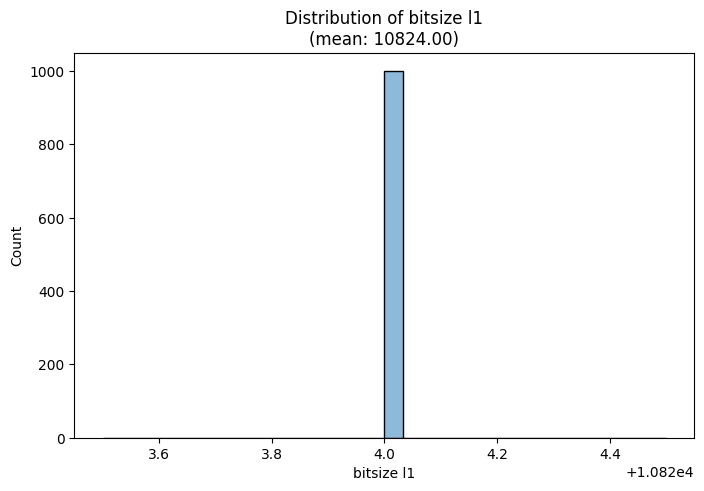

In [3]:
plt.figure(figsize=(8, 5))
sns.histplot(data=one_size_data[:,2], bins=30, kde=True)
plt.title(f'Distribution of bitsize l1\n(mean: {np.mean(one_size_data[:,2]):.2f})')
plt.xlabel('bitsize l1')

plt.ylabel('Count')
plt.show()

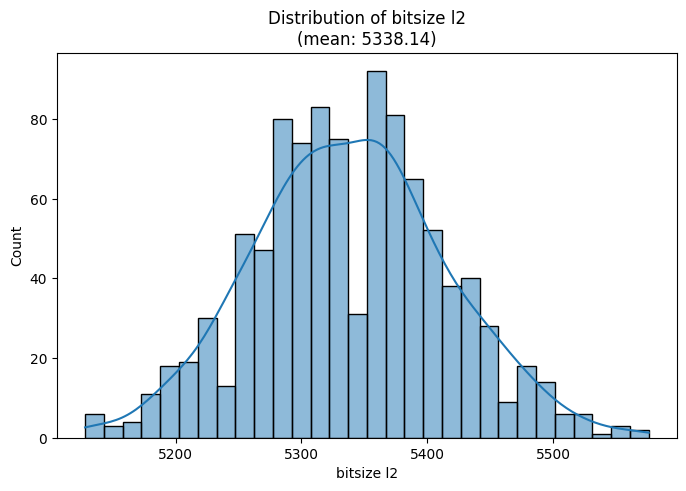

In [4]:

plt.figure(figsize=(8, 5))
sns.histplot(data=one_size_data[:,3], bins=30, kde=True)
plt.title(f'Distribution of bitsize l2\n(mean: {np.mean(one_size_data[:,3]):.2f})')
plt.xlabel('bitsize l2')

plt.ylabel('Count')
plt.show()

In [5]:
from hashlib import sha256
from pickle import dumps
from rbloom import Bloom
import secrets

def generate_single_l2():
    def hash_func(obj):
        h = sha256(dumps(obj)).digest()
        return int.from_bytes(h[:16], "big", signed=True)

    actual_r = 5000
    actual_s = 10000
    #actual_s = 20000
    #actual_s = random.randint(10000, 20000)
    p1 = actual_r*np.sqrt(0.5)/actual_s

    valid_ids = cu.gen_ids(actual_s)
    revoked_ids = cu.gen_ids_wo_overlap(actual_r, valid_ids)

    salt = secrets.token_hex(16)

    bloom = Bloom(actual_r, p1, hash_func, 1)
    for elem in revoked_ids:
        bloom.add(str(elem) + salt)

    fps = 0
    for elem in valid_ids:
        if (str(elem) + salt) in bloom:
            fps += 1

    return fps

one_size_l2_data = np.array([generate_single_l2() for _ in range(400)])

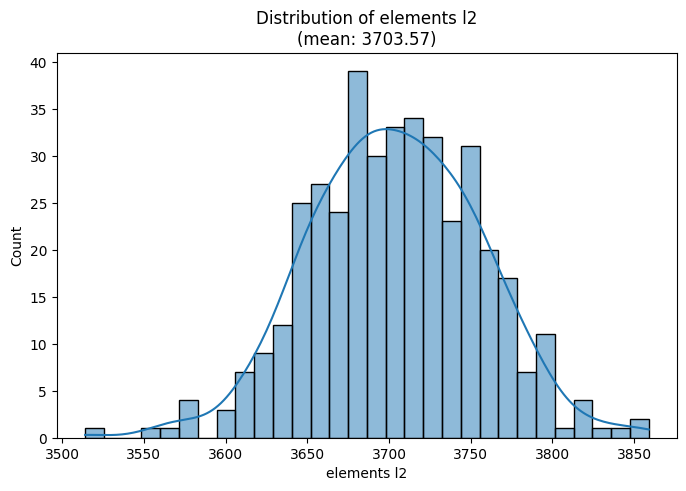

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(data=one_size_l2_data, bins=30, kde=True)
plt.title(f'Distribution of elements l2\n(mean: {np.mean(one_size_l2_data):.2f})')
plt.xlabel('elements l2')

plt.ylabel('Count')
plt.show()

what is going on with l1 inconsistency?

In [7]:
r_values = np.array(range(1000, 10000, 100))
ramp_size_data = np.array([generate_single_cascade_datapoint(i) for i in r_values])

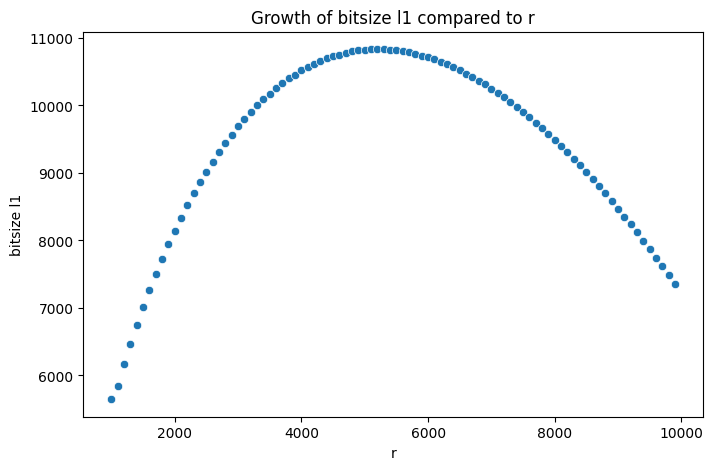

In [8]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
        x=r_values,
        y=ramp_size_data[:,2],
        alpha=1.0,
    )
plt.title(f'Growth of bitsize l1 compared to r')
plt.xlabel('r')

plt.ylabel('bitsize l1')
plt.show()

Do we mess up serialization?

In [9]:
import base64
from src.utils.cascade_property_vectorizer import get_vector_from_string

def get_cascade_bitstrings(cascade):
    """Extract bitstrings from cascade filters."""
    bitstrings = []
    for bloom_filter in cascade.filters:
        bitstring = bloom_filter.save_bytes()
        bitstring = base64.urlsafe_b64encode(bitstring[8:]).decode("utf-8")
        bitstrings.append(bitstring)
    return ",".join(bitstrings)

def generate_single_cascade(r):
    actual_r = r
    actual_s = 10000

    # Generate valid IDs
    valid_ids = cu.gen_ids(actual_s)

    # Generate revoked IDs
    revoked_ids = cu.gen_ids_wo_overlap(actual_r, valid_ids)

    cascade, _ = cu.try_cascade(
        valid_ids,
        revoked_ids,
        None,
        p=0.5,
        k=1,
        use_padding=False,
    )

    return cascade

ramp_cascade_data = np.array([generate_single_cascade(i) for i in r_values])
ramp_recoded_data = np.array([get_cascade_bitstrings(cascade) for cascade in ramp_cascade_data])
ramp_recoded_vectors = np.array([get_vector_from_string(bitstring) for bitstring in ramp_recoded_data])

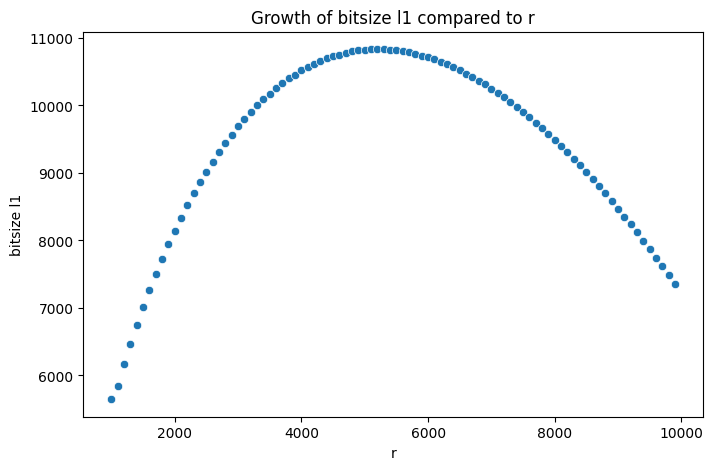

In [10]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
        x=r_values,
        y=ramp_recoded_vectors[:,2],
        alpha=1.0,
    )
plt.title(f'Growth of bitsize l1 compared to r')
plt.xlabel('r')

plt.ylabel('bitsize l1')
plt.show()

what if we randomly select r? should not make a difference, but still

In [11]:
r_values_random = np.array([random.randint(1000, 10000) for _ in range(100)])
ramp_size_data_random = np.array([generate_single_cascade_datapoint(i) for i in r_values_random])

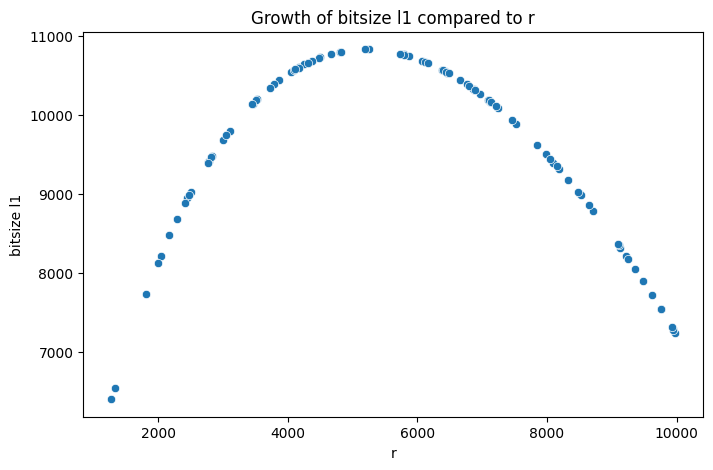

In [12]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
        x=r_values_random,
        y=ramp_size_data_random[:,2],
        alpha=1.0,
    )
plt.title(f'Growth of bitsize l1 compared to r')
plt.xlabel('r')

plt.ylabel('bitsize l1')
plt.show()